In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="darkgrid")

In [27]:
df = pd.read_csv('../data/transform/match_details_transformed.csv')
selected_columns_with_target = [
    'home_avg_goals_scored', 'away_avg_goals_scored', 'home_avg_goals_conceded', 'away_avg_goals_conceded', 'home_wins', 'away_wins', 'home_team_strength', 'away_team_strength', 'weighted_wins_diff', 'home_streak_wins', 'away_streak_wins', 'home_sum_points', 'away_sum_points', 'points_diff', 'win_eachother_home', 'win_eachother_away', 'avg_possession_home', 'avg_possession_away', 'avg_shoton_home', 'avg_shoton_away', 'result_match'
]

selected_df = df[selected_columns + ['result_match']]

In [30]:
# Summary statistics
summary_stats = selected_df.describe()

summary_stats

,home_avg_goals_scored,away_avg_goals_scored,home_avg_goals_conceded,away_avg_goals_conceded,home_wins,away_wins,home_team_strength,away_team_strength,weighted_wins_diff,home_streak_wins,...,home_sum_points,away_sum_points,points_diff,win_eachother_home,win_eachother_away,avg_possession_home,avg_possession_away,avg_shoton_home,avg_shoton_away,result_match
count,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,...,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000
mean,1.320724,1.369405,1.355484,1.326793,6.766447,6.844079,76.336793,76.162296,-0.450658,0.582566,...,13.236513,13.506250,-0.269737,1.604605,1.676974,48.943161,49.140753,48.943161,49.140753,1.172039
std,0.697689,0.709729,0.493775,0.479834,5.322263,5.297348,4.111569,4.096966,41.351305,1.184700,...,5.742785,5.701927,7.661496,1.984369,1.990334,5.886845,5.817418,5.886845,5.817418,0.844435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.550000,56.550000,-168.000000,0.000000,...,0.000000,0.000000,-28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.750000,1.000000,1.000000,1.000000,3.000000,3.000000,73.550000,73.360000,-19.000000,0.000000,...,9.000000,9.000000,-5.000000,0.000000,0.000000,47.000000,47.100000,47.000000,47.100000,0.000000
50%,1.250000,1.250000,1.300000,1.300000,6.000000,6.000000,75.730000,75.640000,0.000000,0.000000,...,13.000000,13.000000,0.000000,1.000000,1.000000,49.700000,49.800000,49.700000,49.800000,1.000000
75%,1.750000,1.750000,1.700000,1.600000,10.000000,10.000000,79.360000,79.270000,17.000000,1.000000,...,17.000000,18.000000,5.000000,2.000000,2.000000,51.900000,52.000000,51.900000,52.000000,2.000000
max,5.500000,5.750000,4.000000,4.000000,27.000000,28.000000,88.000000,87.450000,159.000000,11.000000,...,30.000000,30.000000,25.000000,11.000000,12.000000,64.300000,64.300000,64.300000,64.300000,2.000000


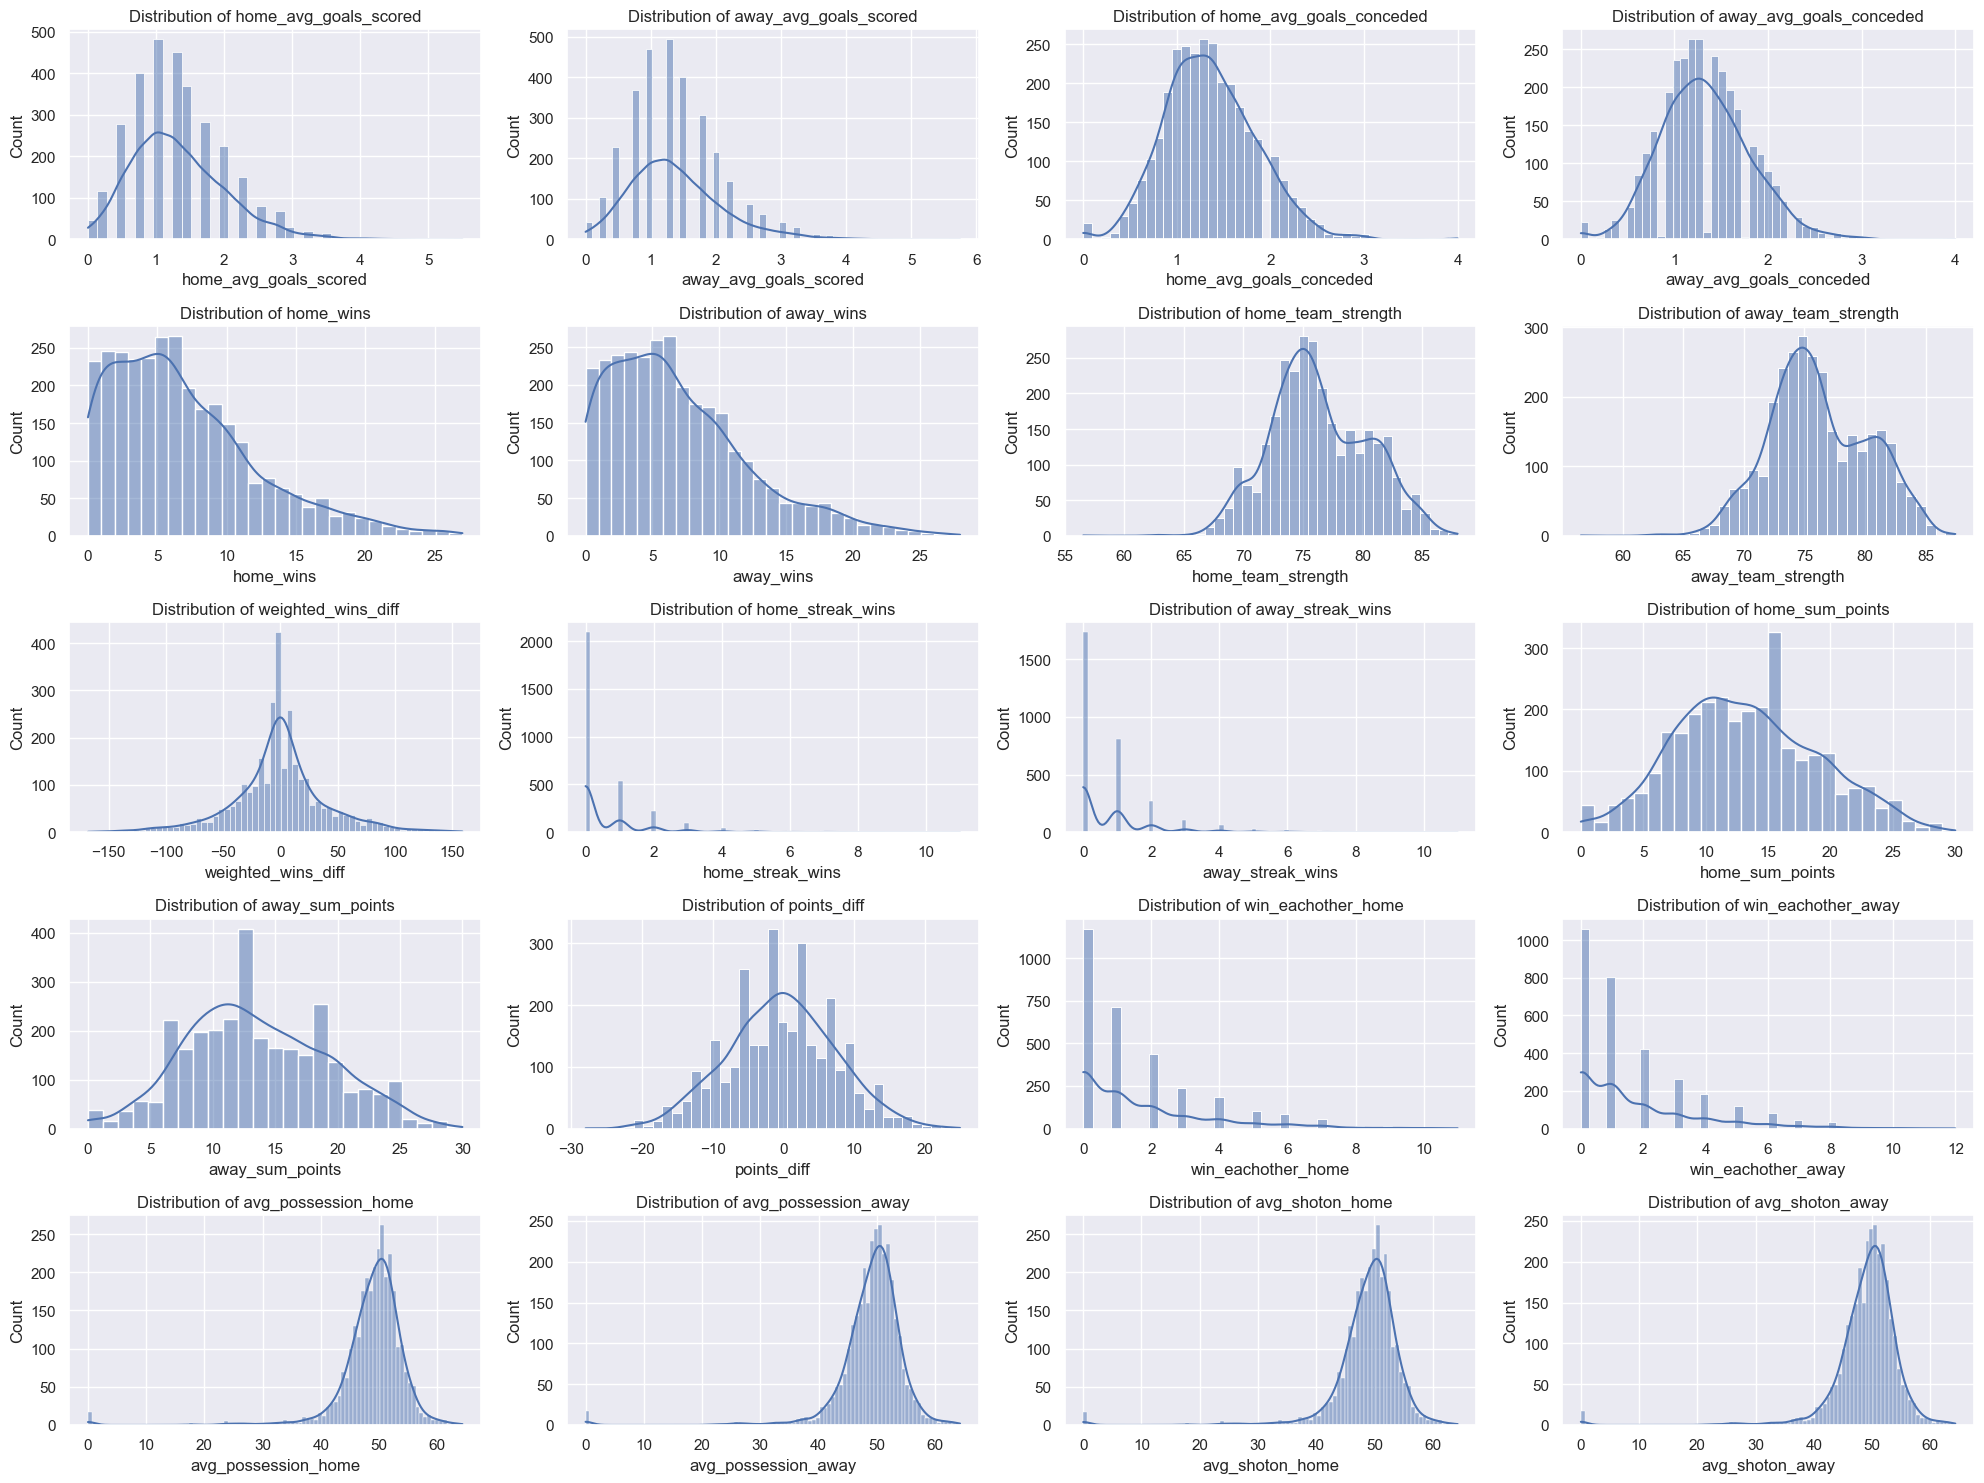

In [44]:
# Selected columns for EDA

selected_columns = [
    'home_avg_goals_scored', 'away_avg_goals_scored', 'home_avg_goals_conceded', 'away_avg_goals_conceded', 'home_wins', 'away_wins', 'home_team_strength', 'away_team_strength', 'weighted_wins_diff', 'home_streak_wins', 'away_streak_wins', 'home_sum_points', 'away_sum_points', 'points_diff', 'win_eachother_home', 'win_eachother_away', 'avg_possession_home', 'avg_possession_away', 'avg_shoton_home', 'avg_shoton_away',
]

df_subset = selected_df[selected_columns_with_target]

# Plotting distributions for the selected columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(selected_columns, 1):
    plt.subplot(5, 4, i)
    sns.histplot(df_subset[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

In [24]:
# - Some variables (like home_avg_goals_scored, away_avg_goals_scored, etc.) appear to be normally distributed.
# - Others, such as home_wins and away_wins, are skewed to the right.
# - Some columns (like win_eachother_home and win_eachother_away) seem to be categorical or binary, as they have distinct peaks.

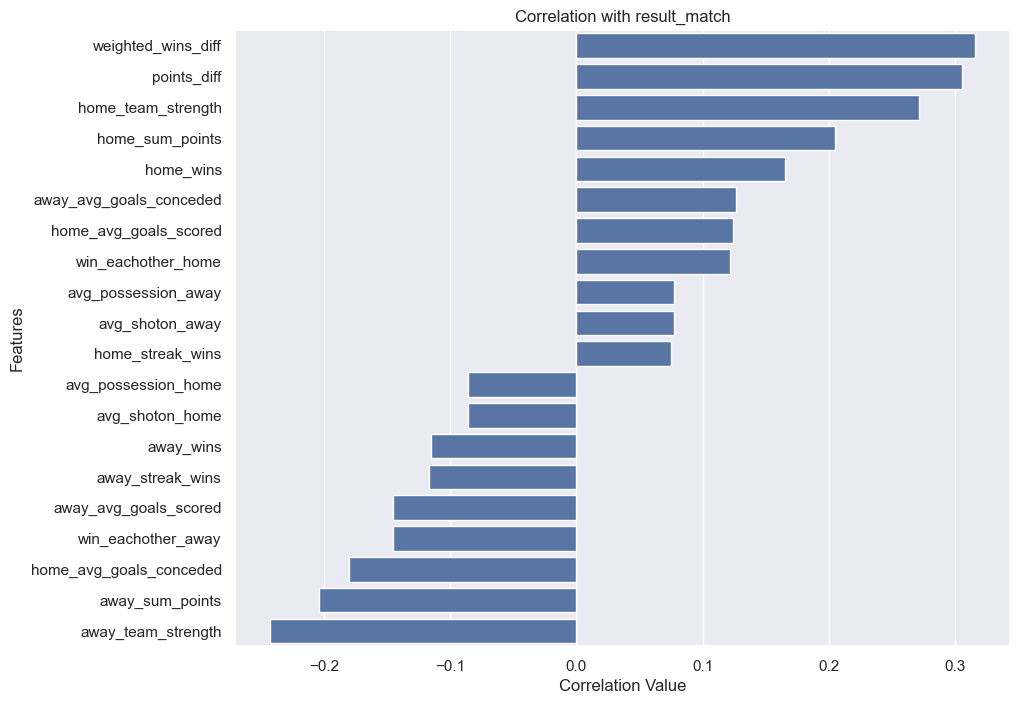

In [52]:
# Compute the correlation between the selected columns and the target variable
correlation = selected_df.corr()['result_match'].sort_values(ascending=False).drop(['result_match'])

# Plot the correlations
plt.figure(figsize=(10, 8))
sns.barplot(y=correlation.index, x=correlation.values, legend=False)
plt.title("Correlation with result_match")
plt.xlabel("Correlation Value")
plt.ylabel("Features")
plt.show()

In [ ]:
# - weigthed_wins_diff, points_diff and home_team_strength have positive correlations, implying that higher values in these features could favor the home team's win.

In [ ]:
# - away_sum_points, home_avg_goals_conceded, and away_team_strength have negative correlations, implying that higher values in these features could favor the away team's win.

In [61]:
selected_df['result_match'] = selected_df['result_match'].map({0: 'Away win', 1: 'Draw', 2: 'Home win'})

C:\Users\kamil\AppData\Local\Temp\ipykernel_11136\88140328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['result_match'] = selected_df['result_match'].map({0: 'Away win', 1: 'Draw', 2: 'Home win'})


In [62]:
selected_df['result_match']

0       Home win
1       Away win
2       Home win
3       Away win
4       Home win
          ...   
3035    Home win
3036        Draw
3037    Home win
3038    Home win
3039    Home win
Name: result_match, Length: 3040, dtype: object

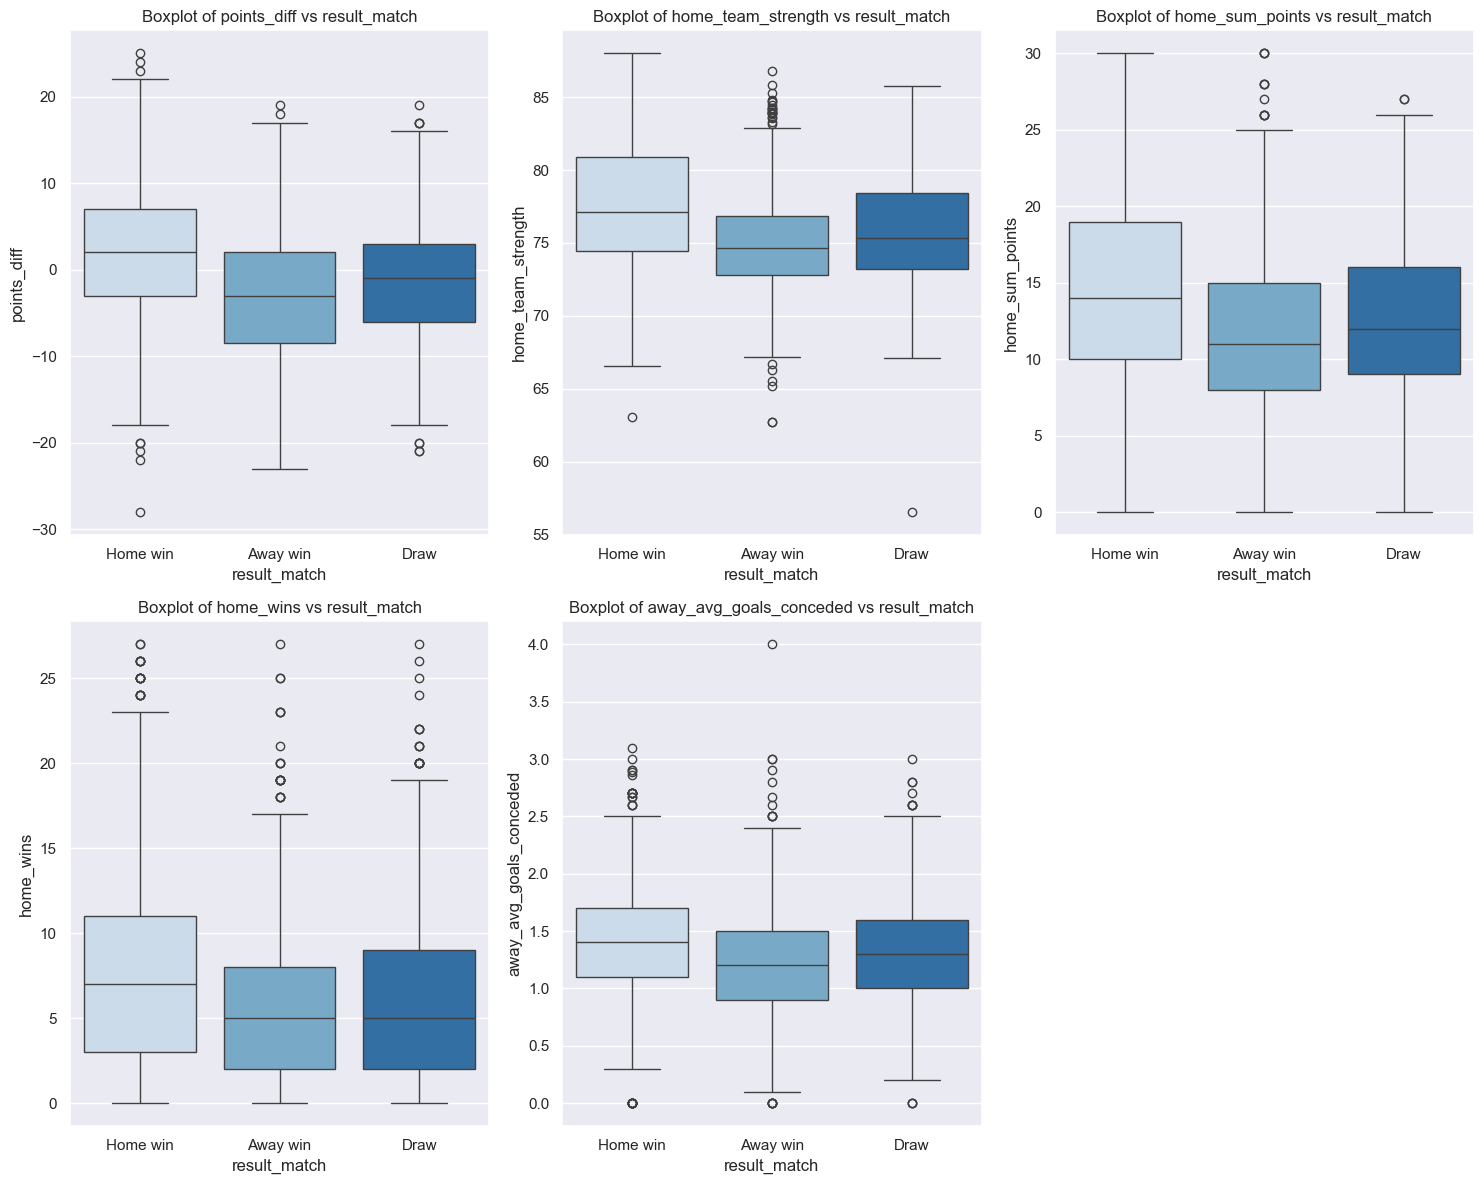

In [63]:
# Get top 5 positively and negatively correlated features
top_pos_correlated = correlation.index[1:6]  # Exclude the target variable itself
top_neg_correlated = correlation.index[-5:]

# Plotting the top 5 positively correlated features against result_match
plt.figure(figsize=(15, 12))
for i, feature in enumerate(top_pos_correlated, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="result_match", y=feature, data=selected_df, palette="Blues", hue='result_match', legend=False)
    plt.title(f"Boxplot of {feature} vs result_match")

plt.tight_layout()
plt.show()

In [ ]:
# - weigthed_wins_diff:
# For result_match = 0: The median is negative, indicating that the away team typically has a higher weighted win score than the home team for this result category (possibly an away win).
# For result_match = 1: The distribution is more centered around zero, but still slightly skewed towards positive values.
# For result_match = 2: The median value is positive, suggesting that the home team generally has a higher weighted win score compared to the away team (possibly a home win).

# - points_diff: 
# For result_match = 0: The median points_diff is negative, indicating that the away team typically has more points than the home team when the match result is 0 (possibly an away win).
# For result_match = 1: The points_diff is centered around zerosuggesting that both teams are relatively evenly matched in terms of points when the result is a draw, but still slightly skewed towards negative values.
# For result_match = 2: The median points_diff is positive, indicating that the home team generally has more points than the away team when the match result is 2 (possibly a home win).

In [64]:
def detect_outliers(data):
    # Calculate Q1, Q2 and IQR
    Q1 = data.quantile(0.15)
    Q3 = data.quantile(0.85)
    IQR = Q3 - Q1
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Identify outliers
    return ((data < lower_bound) | (data > upper_bound)).sum()

outliers_count = detect_outliers(selected_df.drop(columns="result_match"))
outliers_count

home_avg_goals_scored       10
away_avg_goals_scored       12
home_avg_goals_conceded      4
away_avg_goals_conceded      1
home_wins                    0
away_wins                    1
home_team_strength           1
away_team_strength           1
weighted_wins_diff          16
home_streak_wins           190
away_streak_wins            33
home_sum_points              0
away_sum_points              0
points_diff                  0
win_eachother_home           5
win_eachother_away           6
avg_possession_home         52
avg_possession_away         48
avg_shoton_home             52
avg_shoton_away             48
dtype: int64

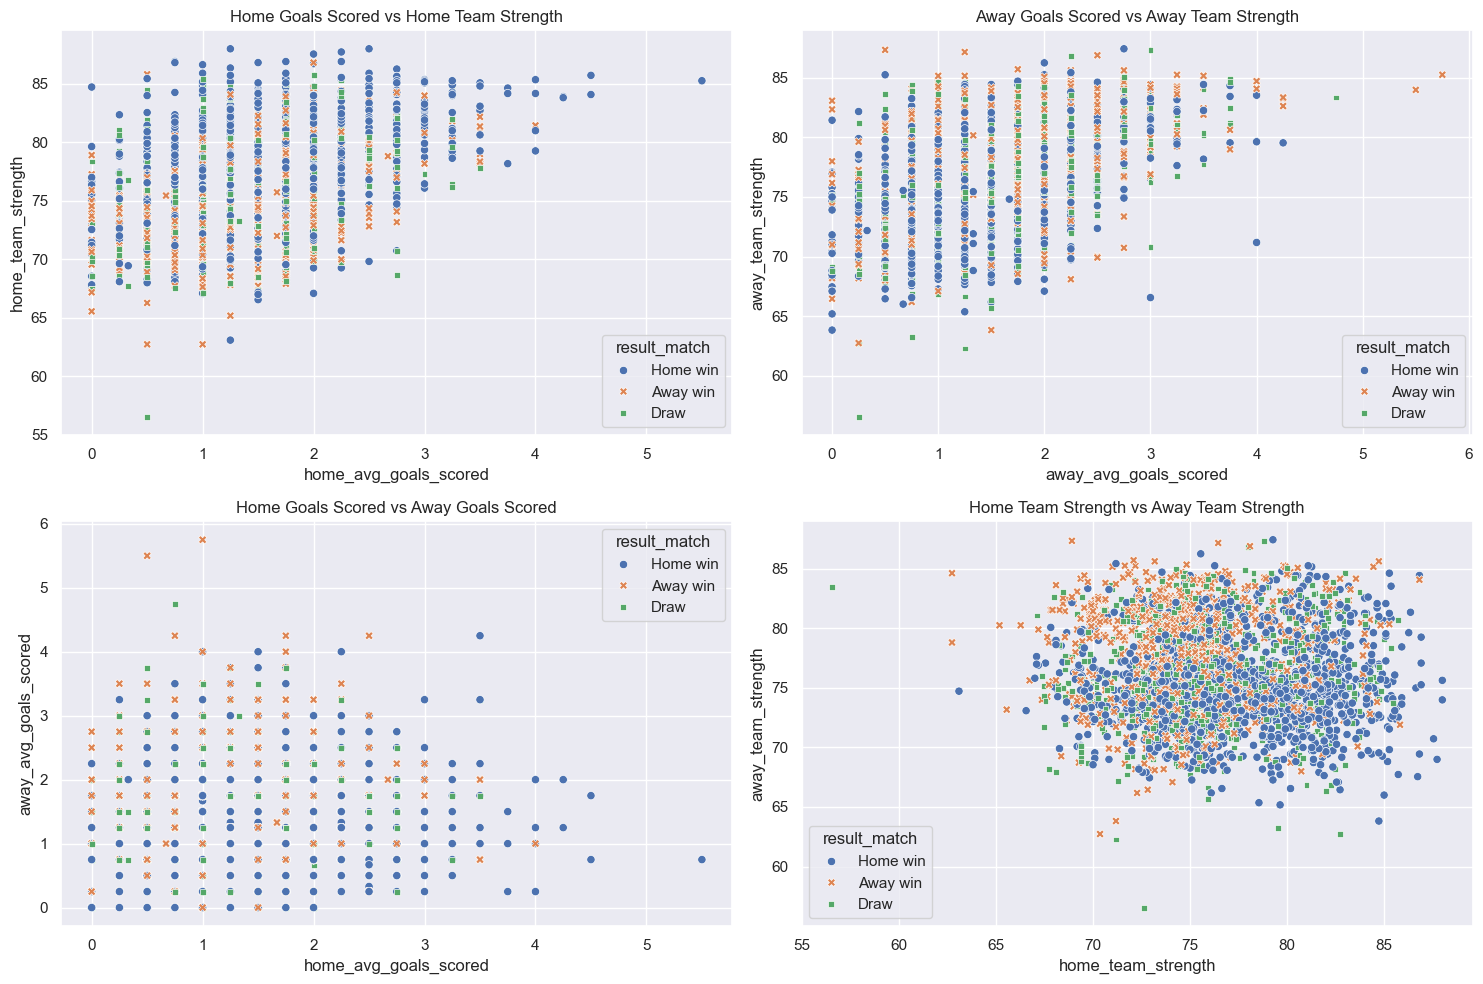

In [69]:
# Plot interactions between goal-related features and team strength
plt.figure(figsize=(15, 10))

# Interaction between home_avg_goals_scored and home_team_strength
plt.subplot(2, 2, 1)
sns.scatterplot(x='home_avg_goals_scored', y='home_team_strength', hue='result_match', data=selected_df, palette='deep', style='result_match')
plt.title('Home Goals Scored vs Home Team Strength')

# Interaction between away_avg_goals_scored and away_team_strength
plt.subplot(2, 2, 2)
sns.scatterplot(x='away_avg_goals_scored', y='away_team_strength', hue='result_match', data=selected_df, palette='deep', style='result_match')
plt.title('Away Goals Scored vs Away Team Strength')

# Interaction between home_avg_goals_scored and away_avg_goals_scored
plt.subplot(2, 2, 3)
sns.scatterplot(x='home_avg_goals_scored', y='away_avg_goals_scored', hue='result_match', data=selected_df, palette='deep', style='result_match')
plt.title('Home Goals Scored vs Away Goals Scored')

# Interaction between home_team_strength and away_team_strength
plt.subplot(2, 2, 4)
sns.scatterplot(x='home_team_strength', y='away_team_strength', hue='result_match', data=selected_df, palette='deep', style='result_match')
plt.title('Home Team Strength vs Away Team Strength')

plt.tight_layout()
plt.show()

In [ ]:
# - Home Goals Scored vs Home Team Strength:

# There's a general trend suggesting that stronger teams (with higher strength values) tend to score more goals on average.
# The color hue (representing match results) indicates that when the home team scores more goals, they are more likely to win.

# - Away Goals Scored vs Away Team Strength:

# Similar to home teams, there's a trend where stronger away teams tend to score more goals on average.
# Matches where the away team scores more goals are more likely to result in an away win.

# - Home Goals Scored vs Away Goals Scored:

# Trend suggests that when home_avg_goals_scored is bigger than away_avg_goals_scored than home team win.
# Points above the diagonal line indicate home wins, and points below the diagonal line suggest away wins.

# - Home Team Strength vs Away Team Strength:

# There's a concentration of points around the center, indicating that many matches are between teams of similar strengths.
# The color hue shows that when the away team is stronger, they are more likely to win, and vice versa.

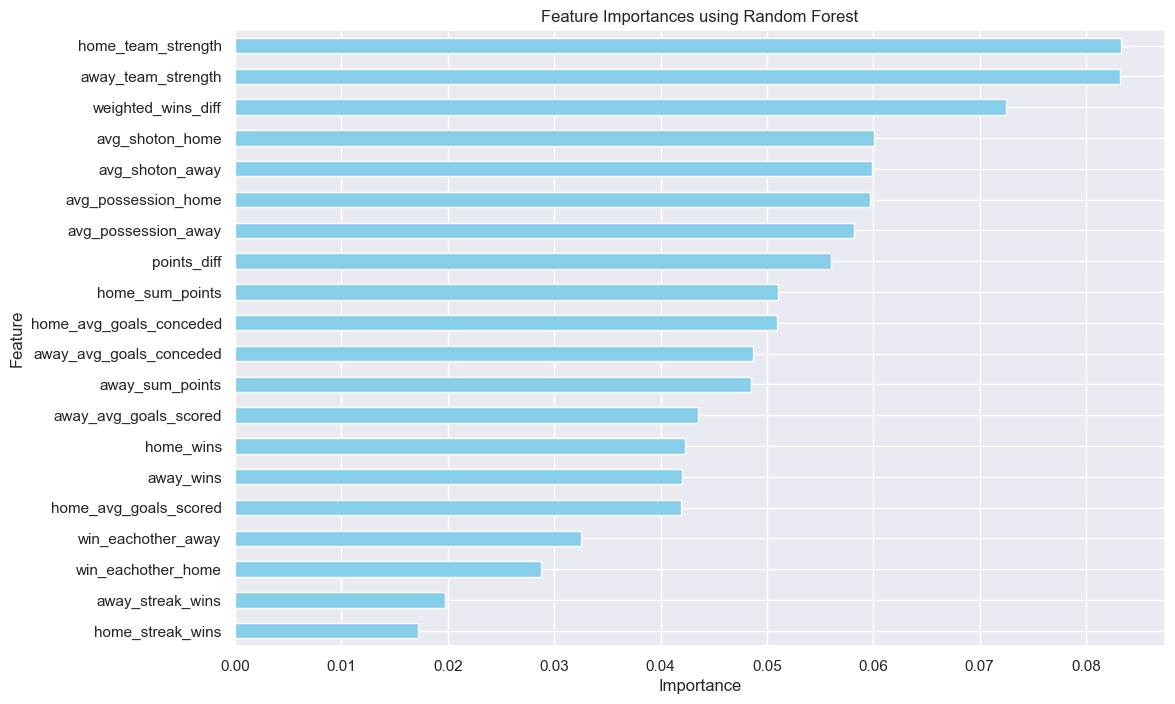

In [70]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Split the data into features and target
X = selected_df.drop(columns="result_match")
y = selected_df["result_match"]

# Fit the model
rf.fit(X, y)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='barh', color='skyblue')
plt.title('Feature Importances using Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

In [72]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort by VIF values in descending order
vif_sorted = vif_data.sort_values(by="VIF", ascending=False)
vif_sorted

C:\Users\kamil\anaconda3\envs\py10\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
19,avg_shoton_away,inf
16,avg_possession_home,inf
18,avg_shoton_home,inf
11,home_sum_points,inf
12,away_sum_points,inf
13,points_diff,inf
17,avg_possession_away,inf
5,away_wins,751.590401
4,home_wins,747.540511
7,away_team_strength,651.880111


In [ ]:
# Features such as avg_shoton_away, avg_possession_home, avg_shoton_home, home_sum_points, away_sum_points, points_diff, and avg_possession_away have infinite VIF values, suggesting they are perfectly (or near-perfectly) correlated with other features in the dataset. These features might need to be dropped or combined with others to avoid multicollinearity issues.
# Features away_wins, home_wins, away_team_strength, and home_team_strength have high VIF values, indicating potential multicollinearity with other features.

In [ ]:
# 1. Match Outcome by Team Strength

# Creating a new column to indicate which team has higher strength
data['stronger_team'] = 'draw'
data.loc[data['home_team_strength'] > data['away_team_strength'], 'stronger_team'] = 'home'
data.loc[data['home_team_strength'] < data['away_team_strength'], 'stronger_team'] = 'away'

# Mapping result_match to outcomes
outcomes = {0: 'away_win', 1: 'draw', 2: 'home_win'}
data['match_outcome'] = data['result_match'].map(outcomes)

# Counting outcomes based on which team was stronger
strength_outcome = data.groupby(['stronger_team', 'match_outcome']).size().unstack()

In [ ]:
# Teams deemed "stronger" (either the home or away team) tend to win more often,
# as evidenced by the larger segments for "home_win" and "away_win" respectively.
strength_outcome

In [ ]:
# 2. Effect of Streaks

# Filtering matches where home streak is bigger than away streak 
streak_threshold = 2
streak_data = data[data['home_streak_wins'] > data['away_streak_wins']]

# Counting outcomes based on streaks
streak_outcomes = streak_data.groupby(['match_outcome']).size()

streak_outcomes.plot(kind='pie', figsize=(8, 6), colormap='Set3', autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Match Outcomes when a home team is on a Streak')
plt.ylabel('')  # Removing the default ylabel
plt.tight_layout()
plt.show()